<a href="https://colab.research.google.com/github/imji0319/PDSH/blob/master/Mercari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/data

/content/gdrive/My Drive/data


In [3]:
ls

 credit_card.xls   mercari_train.tsv  'Online Retail.xlsx'


In [0]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

# 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격 예측하는 과제.
- 제공 데이터 세트 : 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터
- 판매자는 제품명, 브랜드명, 카테고리, 제품 설명 등 다양한 속성 정보를 입력하고, 이러한 속성에 따라 제품의 예측 가격을 판매자에게 자동 제공
- 회귀로 피처를 학습한 뒤 price를 예측


In [5]:
mercari_df = pd.read_csv('mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


제공 데이터 세트의 속성

* train_id : 데이터 id
* name : 제품명
* item_condition_id : 판매자가 제공하는 제품의 상태
* category_name : 카테고리 명
* brand_name : 브랜드 이름
* price : 제품 가격, 타깃 속성
* shipping : 배송비 무료 여부, 1 : 무료 / 0 : 유료
* Item_description : 제품에 대한 설명 




## 데이터 전처리(Preprocessing)

#### 데이터 세트의 feature 타입과 Null 여부

In [6]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name : 매우 많은 Null 값을 가짐
- category_name : 약 6300건의 Null 값을 가짐
- item_description : Null 값 4개

#### Target 인 price의 데이터 분포도

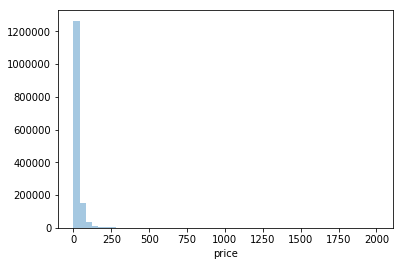

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.distplot(y_train_df, kde = False)

price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포

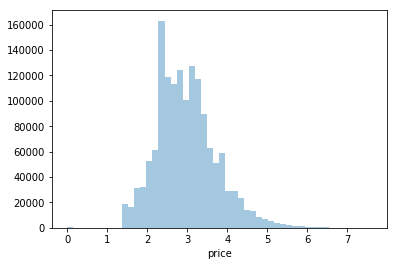

In [8]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

#### log 값으로 변환하면 비교적 정규 분포에 가까운 데이터를 이룸.
데이터 세트의 price 값을 원래 값에서 로그 변환 값으로 변경



In [9]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [13]:
print('Shipping 값 유형 : \n',mercari_df['shipping'].value_counts())
print('item_condition_id : \n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형 : 
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id : 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


* shipping 은 배송비 유무이며, 값이 비교적 균일
* item_condition_id : 판매자가 제공하는 제품 상태로 각 값이 의미하는 바를 알 수 없지만 1,2,3 값이 주로 이룸



In [14]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

* item_desciption의 Null 값은 별로 없지만 별로 설명이 없는 경우 'No description yet' 이라고 표현되어 있음.
* Null과 같이 의미 없는 값으로 적절한 값으롤 변경해야 함 

category_name은 '/' 로 분리된 카테고리를 하나의 문자열로 나타냄 -> '/' 를 기준으로 단어 토큰화

In [0]:
# category_name을 '/' 기준으로 분할할 함수
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

In [0]:
# apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df 에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                                                                    zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [18]:
# 대분류 값의 유형과 건수, 중분류와 소분류의 분류 개수
print('대분류 유형 : \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형 : \n', mercari_df['cat_jung'].nunique())
print('소분류 유형 : \n', mercari_df['cat_so'].nunique())

대분류 유형 : 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 유형 : 
 114
소분류 유형 : 
 871


In [19]:
# brand_name, category_name, item_desciption 칼럼의 Null 값을 일괄적으로 'Other Null'로 동일하게 변경

mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other Null')

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## Feature incoding과 feature Vectorization

### brand_name : 상품의 브랜드명

In [20]:
print('brand_name 의 유형 건수 : ', mercari_df['brand_name'].nunique() )
print('brand_name 의 sample  5건 : ', mercari_df['brand_name'].value_counts()[:5] )

brand_name 의 유형 건수 :  4810
brand_name 의 sample  5건 :  Other Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


대부분 명료한 문자열로 되어 있어 별도의 피처 벡터화 형태로 만들 필요는 없이 인코딩 변환 작업 

### name : 상품명

In [22]:
print('name 의 종류 개수 : ', mercari_df['name'].nunique() )
print('name 의 sample  10건 : \n', mercari_df['name'][:10] )

name 의 종류 개수 :  1225273
name 의 sample  10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


* 상품명인 name의 속성의 종류 매우 많음. 
* 전체 데이터가 1,482,535개 임으로 개별적으로 거의 고유한 상품명을 가지고 있음. 
* Name 속성은 유형이 매우 적고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환을 적용


### shipping : 배송비 유무
0과 1, 두가지 유형을 가짐

### item_conditon_id : 상품 상태
1,2,3,4,5 의 다섯 가지 유형의 값을 가지고 있음.

-> 모두 원 - 핫 인코딩 적용

### item_description :  상품 설명

In [23]:
pd.set_option('max_colwidth', 200)

# item_description 의 평균 문자열 크기
print( 'item_description 평균 문자열 크기 : ' , mercari_df['item_description'].str.len().mean() )

mercari_df['item_description'][:2]

item_description 평균 문자열 크기 :  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

### Feature Vectorization
name 칼럼의 경우 CountVectorization 하고, item_description 칼럼의 경우 TfidfVectorization 처리

In [24]:
# name 속성에 대한 피처 벡터화 변환 
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range =(1,3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print( 'name vectorization shape : ', X_name.shape )
print( 'item_description vectorization shape : ', X_descp.shape )


name vectorization shape :  (1482535, 105757)
item_description vectorization shape :  (1482535, 50000)


원 - 핫 인코딩 : brand_name, shipping, item_condition_id, cat_dae, cat_jung, cat_so 

희소행렬 형태의 원 - 핫 인코딩 : LableBinarizer

In [0]:
from sklearn.preprocessing import LabelBinarizer

# brabd_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])


lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])



# cat_dae, cat_jung, cat_so 각 피쳐들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [31]:
print(type(X_brand), type(X_item_cond), type(X_shipping))
print('X_brand shape : {0} , X_item_cond_id : {1}'.format(X_brand.shape, X_item_cond.shape) )
print('X_shipping shape : {0} , X_cat_dae : {1}'.format(X_shipping.shape, X_cat_dae.shape) )
print('X_cat_jung shape : {0} , X_cat_so : {1}'.format(X_cat_jung.shape, X_cat_so.shape) )

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape : (1482535, 4810) , X_item_cond_id : (1482535, 5)
X_shipping shape : (1482535, 1) , X_cat_dae : (1482535, 11)
X_cat_jung shape : (1482535, 114) , X_cat_so : (1482535, 871)


In [35]:
from scipy.sparse import hstack
import gc 

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond, \
                                X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


1106

hstack()으로 결합한 데이터 세트는 csr_matrix 타입

## 릿지 회귀 모델 구축 및 평가
평가 지표 : 캐글에서 제시한 RMSLE(Root Mean Square Logarithmic Error) 방식 적용

In [0]:
def rmsle(y, y_pred):
    
    # underflow, overflow 를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred),2 )))


def evaluate_org_price(y_test, preds):
    
    # 원본 데이터는 log1p로 변환되었음으로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    
    #rmsle 로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [0]:
def model_train_predict(model, matrix_list):
    
    # scipy.sparse 모듈의 hstack 을 이용해 희소행렬 결합
    
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size = 0.2, random_state = 156 )
    
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test


In [44]:
# Ridge 회귀 모델 구축

linear_model = Ridge(solver = "lsqr", fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Desciption 을 제외했을 때 rmsle 값 : ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Desciption 을 포함한 rmsle 값 : ', evaluate_org_price(y_test, linear_preds))


Item Desciption 을 제외했을 때 rmsle 값 :  0.5023727038010543
Item Desciption 을 포함한 rmsle 값 :  0.47122110498842595


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [45]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond,
                                 X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)

print('LightGBM rmsle 값 : ', evaluate_org_price(y_test, lgbm_preds))


LightGBM rmsle 값 :  0.45682103517346156


In [46]:
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond,
                                 X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 1500, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)

print('1500 LightGBM rmsle 값 : ', evaluate_org_price(y_test, lgbm_preds))

1500 LightGBM rmsle 값 :  0.45825108491235633


대략 2시간 정도 소요 -> 되려 0.003 정도 상승 : 

In [49]:
pred = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM 과 Ridge를 간단하게 ensemble한 최종 rmsle 값 : ', evaluate_org_price(y_test, pred))

LightGBM 과 Ridge를 간단하게 ensemble한 최종 rmsle 값 :  0.4435017240075626


간단한 앙상블로 rmsle 값 하락 -> 예측 성능 개선